V - расход газо-воздушной смеси (м3/с) : 0.3141592653589793
f - параметр для определения коэфф. m и n: 80.0
fe - параметр для определения коэфф. m и n: 112.4864
vm - параметр для определения коэфф. m и n: 0.5567240456014325
vm2 - параметр для определения коэфф. m и n: 0.52
m коэфф: 0.3300937078358853
n коэфф: 2.109066747558788
S_flow - мощность выброса: 555
s_hight - высоту источника: 555
s_diam - диаметр устья: 555
s_speed - скорость выхода ГВС: 555
Cm - Максимальное значение приземной концентрации вредного вещества : 1477.3791185662067
d коэфф: 6.0805917795539015
wind - скорость ветра: 0.5567240456014325
Xm - Расстояние от источника выбросов, на котором приземная концентрация при метеорологических условиях достигает максимального значения: 30.40295889776951


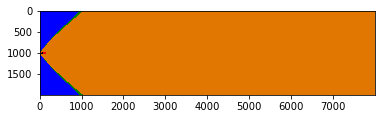

In [20]:
import numpy
from math import pi, sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl

limit_x = 8000                                 # Границы расчётной области в метрах
limit_y = 2000


def c_m(s_flow, s_hight, s_diam, s_speed):  # Расчёт максимальной концентрации.
                                            # Принимает на вход мощность выброса (s_flow), высоту источника (s_hight),
                                            # диаметр устья(s_diam), скорость выхода ГВС (s_speed)

    v = ((pi*s_diam**2)/4)*s_speed          # расчёт объёмного расхода ГВС
    print('V - расход газо-воздушной смеси (м3/с) : %s' % v)
    F = 1                                   # Коэффициент оседания 1 для газа. 2 для мелкодисперсных аэрозолей
    dT = 10                                 # Разница температур ГВС и окружающей среды
    strat = 140                             # Коэффициент стратификации. Принят для Москвы и области.
    f = 1000 * ((s_speed**2)*s_diam)/((s_hight**2)*dT)  # вспомогательные
    vm = 0.65 * ((v*dT)/s_hight)**(1/3)                 # параметры, характеризующие источник
    vm2 = 1.3 * (s_speed * s_diam)/s_hight              # для рассчёта опасной скорости ветра
    fe = 800 * (vm2**3)                                 # и коэффициентов m и n в конечной формуле
    print('f - параметр для определения коэфф. m и n: %s' % f)                  
    print('fe - параметр для определения коэфф. m и n: %s' % fe)
    print('vm - параметр для определения коэфф. m и n: %s' % vm)
    print('vm2 - параметр для определения коэфф. m и n: %s' % vm2)
    if f < 100:
        m = 1/(0.67 + 0.1*sqrt(f) + 0.34*(f**(1/3)))
    else:
        m = 1.47/(f**(1/3))
    print('m коэфф: %s' % m)
    if vm >= 2:
        n = 1
    elif vm >= 0.5:
        n = 0.532*(vm**2) - 2.13*vm + 3.13
    else:
        n = 4.4*vm
    print('n коэфф: %s' % n)
    if f >= 100 and vm2 >= 0.5:
        K = s_diam/8*v
        Cm = ((strat*s_flow*n*F)/(s_hight**(4/3)))*K
    elif f < 100 and vm2 < 0.5:
        m = m * 2.86
        Cm = (strat * s_flow * m * F) / (s_hight**(7/3))
    elif f >= 100 and vm2 < 0.5:
        m = 0.9
        Cm = (strat * s_flow * m * F) / (s_hight ** (7 / 3))
    else:
        Cm = (strat*s_flow*m*n*F)/(s_hight**2 *((v*dT)**(1/3)))

    if f >= 100:
        if vm2 < 0.5:
            wind = 0.5
            d = 5.7
        elif vm2 <= 2:
            d = 11.4 * vm2
            wind = vm
        else:
            d = 16 * sqrt(vm2)
            wind = 2.2 * vm2
    else:
        if vm2 < 0.5:
            d = 2.48 * (1 + 0.28*(fe**(1/3)))
            wind = 0.5
        elif vm2 <= 2:
            d = 4.95 * vm * (1 + 0.28 * (f**(1/3)))
            wind = vm
        else:
            d = 7 * sqrt(vm) * (1 + 0.28 * (f ** (1 / 3)))
            wind = vm * (1 + 0.12*sqrt(f))
    print('S_flow - мощность выброса: %s' % s_flow)
    print('s_hight - высоту источника: %s' % s_flow) 
    print('s_diam - диаметр устья: %s' % s_flow) 
    print('s_speed - скорость выхода ГВС: %s' % s_flow) 
    print('Cm - Максимальное значение приземной концентрации вредного вещества : %s' % Cm)
    print('d коэфф: %s' % d)
    print('wind - скорость ветра: %s' % wind)
    return Cm, wind, d


def Pollution_ond (x0, y0, s_hight, Cm, wind, d,  pdk):  # Собственно рассчёт рассеивания. Вычисление концентрации по оси факела
                                                # с последующим расчётом в точках, перпендиклярным оси
    Num = numpy.zeros((limit_y, limit_x))
    F = 1
    Xm = ((5-F)/4)*d*s_hight
    print('Xm - Расстояние от источника выбросов, на котором приземная концентрация при метеорологических условиях достигает максимального значения: %s' % Xm)
    for j in range(x0+1, limit_x):             # Цикл, идущий по оси Х. Совпадает с осью факела.
        dx = j - x0
        if dx/Xm <= 1:
            if s_hight >= 2 and s_hight < 11:
                S = 0.125 * (10 - s_hight) + 0.125 * (s_hight - 2)
            else:
                S = 3*(dx/Xm)**4 - 8*(dx/Xm)**3 + 6*(dx/Xm)**2
        elif dx/Xm <= 8:
            S = 1.113/(0.13*(dx/Xm)**2 + 1)
        elif dx/Xm > 8 and dx/Xm <= 100:
            if F <= 1.5:
                S = (dx/Xm)/(3.556*(dx/Xm)**2 - 35.2*(dx/Xm) + 120)
            else:
                S = 1 / (0.1 * (dx / Xm) ** 2 + 2.456 * (dx / Xm) - 17.8)
        else:
            if F <= 1.5:
                S = 144.3 *(dx/Xm)**(-7/3)
            else:
                S = 37.76 *(dx/Xm)**(-7/3)
        Num[y0, j] = (Cm * S)/pdk    # Здесь вычисляется концентрация в конечной точке по Х. Она же сразу делится на ПДК

        for i in range(limit_y):  # Цикл, идущий по оси Y. Вызывается в каждой точки оси факела и рассчитывает перпендекулярно
            dy = i - y0
            if wind <= 5:
                ty = (wind*(dy**2))/(dx**2)
            else:
                ty = (5*(dy**2))/(dx**2)
            S = ((1+5*ty+12.8*ty**2+17*ty**3+45.1*ty**4)**2)**(-1)
            if i != y0:
                Num[i, j] = Num[y0, j] * S
    return Num


source_params = c_m(555, 5, 0.2, 10)
source_diffusion = Pollution_ond(0, 1000, 5, source_params[0], source_params[1], source_params[2], 0.1)
# print (source_params[0]/0.2/2)
# print (source_params[0]/0.2-0.25)
# print (source_params[0]/0.2)
plt.figure()
cmap = mpl.colors.ListedColormap(['blue', 'green', 'xkcd:pumpkin', 'red', 'black'])
bounds = [0.1, 0.5, 1, source_params[0]/0.2/2, source_params[0]/0.2-0.25, source_params[0]/0.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(source_diffusion, cmap=cmap, norm=norm)
plt.show()